# Prototype network

In [1]:
using Flux
using Plots
using Printf
pyplot();

In [2]:
function trueTemperatureFun(t::Real)
  intc = Float32(100)
  midp = Float32(50)
  grad = Float32(8/5)
  Float32(intc - grad*abs(t - midp))
end
function range32(start::Real, stop::Real, step::Real)
  # Float32 type StepRangeLen
  res = range(Float32(start), stop=Float32(stop), step = Float32(step))
  return StepRangeLen{Float32,Float32,Float32}(res)
end;

In [3]:
tDomain = Float32[0.1, 5.3, 15.5, 25.5, 39.9, 45.3, 55.5, 65.5, 89.9, 99.5]
tempData = trueTemperatureFun.(tDomain)

10-element Array{Float32,1}:
 20.159996
 28.479996
 44.8
 60.8
 83.840004
 92.479996
 91.2
 75.2
 36.159996
 20.799995

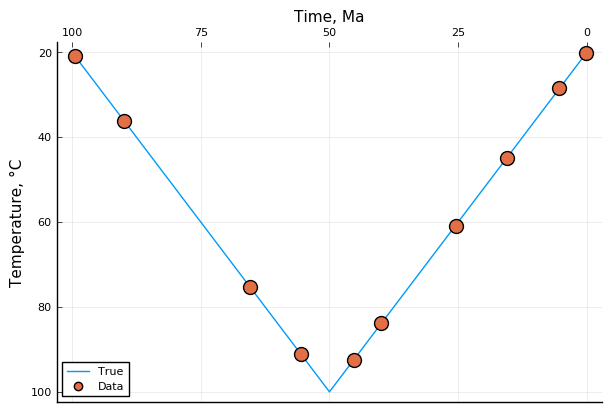

In [16]:
tforPlot = collect(range32(0, 100, 0.1))
trueTemperature = trueTemperatureFun.(tforPlot)
plot(tforPlot, trueTemperature,
label = "True",
xmirror=true)
scatter!(tDomain, tempData, markersize = 10, label = "Data")
plot!(xaxis = ("Time, Ma", :flip))
plot!(yaxis = ("Temperature, °C", :flip))
#savefig("originalData.pdf")

### Making network

In [5]:
struct MapIn{T<:Tuple}
    layers::T
    MapIn(xs...) = new{typeof(xs)}(xs)
end
applychain(::Tuple{}, x) = x
applychain(fs::Tuple, x) = applychain(Base.tail(fs), first(fs)(x))
(a::MapIn)(x) = broadcast(y -> applychain(a.layers, y), x)
(a::MapIn)(x::Array{Float32,1}) = broadcast(first, a(map(y -> [y], x)))
Flux.trainable(a::MapIn) = a.layers

In [6]:
println((tDomain, tempData))
#data = [(tDomain, tempData)]
data = Iterators.repeated((tDomain, tempData), 10000)

(Float32[0.1, 5.3, 15.5, 25.5, 39.9, 45.3, 55.5, 65.5, 89.9, 99.5], Float32[20.159996, 28.479996, 44.8, 60.8, 83.840004, 92.479996, 91.2, 75.2, 36.159996, 20.799995])


Base.Iterators.Take{Base.Iterators.Repeated{Tuple{Array{Float32,1},Array{Float32,1}}}}(Base.Iterators.Repeated{Tuple{Array{Float32,1},Array{Float32,1}}}((Float32[0.1, 5.3, 15.5, 25.5, 39.9, 45.3, 55.5, 65.5, 89.9, 99.5], Float32[20.159996, 28.479996, 44.8, 60.8, 83.840004, 92.479996, 91.2, 75.2, 36.159996, 20.799995])), 10000)

In [7]:
temperatureNet = Chain(
    Dense(1, 16, gelu),
    Dense(16, 32, gelu),
    Dense(32, 64),
    +)
temperatureMap = MapIn(temperatureNet)
typeof(temperatureMap)

MapIn{Tuple{Chain{Tuple{Dense{typeof(gelu),Array{Float32,2},Array{Float32,1}},Dense{typeof(gelu),Array{Float32,2},Array{Float32,1}},Dense{typeof(identity),Array{Float32,2},Array{Float32,1}},typeof(+)}}}}

In [8]:
p, re = Flux.destructure(temperatureNet)
p[p.!=0.0] = Float32.(0.5*randn(sum(p.!=0.0)))
p[p.==0.0] = (50.0 .+ Float32.(10.0*randn(sum(p.==0.0))))
temperatureNet = re(p)
temperatureMap = MapIn(temperatureNet)

MapIn{Tuple{Chain{Tuple{Dense{typeof(gelu),Array{Float32,2},Array{Float32,1}},Dense{typeof(gelu),Array{Float32,2},Array{Float32,1}},Dense{typeof(identity),Array{Float32,2},Array{Float32,1}},typeof(+)}}}}((Chain(Dense(1, 16, gelu), Dense(16, 32, gelu), Dense(32, 64), +),))

In [9]:
initialEstAll = temperatureMap(tforPlot)
initialEst = temperatureMap(tDomain)

10-element Array{Float32,1}:
 -155.77063
 -127.391075
  -71.68035
  -23.277573
   39.410606
   48.188213
   66.28937
   85.920456
  133.79187
  149.85562

In [12]:
parameters = params(temperatureMap)
loss(x, y) = Flux.mae(temperatureMap(x), y)
opt = ADAM(0.01)
evalcb = () -> println(loss(data.xs.x...))

#9 (generic function with 1 method)

In [13]:
Flux.train!(loss, parameters, data, opt, cb = Flux.throttle(evalcb, 1))

80.202
4.1630893
3.5778759
1.5925543
3.9920774
2.4686246
2.5265033
1.6523374
0.537912
0.55957854
1.36056


In [14]:
finalEstAll = temperatureMap(tforPlot)
finalEst = temperatureMap(tDomain)

10-element Array{Float32,1}:
 19.903763
 27.503368
 43.88401
 59.89284
 82.94959
 91.56303
 90.72893
 75.75932
 36.64308
 21.52607

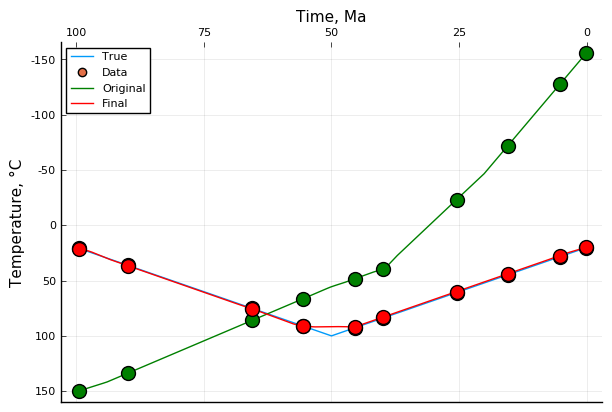

In [17]:
plot(tforPlot, trueTemperature,
    label = "True",
    xmirror=true)
scatter!(tDomain, tempData, markersize = 10, label = "Data")
plot!(tforPlot, initialEstAll, color = "green", label = "Original")
scatter!(tDomain, initialEst, markersize = 10, color = "green", label = "")
plot!(tforPlot, finalEstAll, color = "red", label = "Final")
scatter!(tDomain, finalEst, markersize = 10, color = "red", label = "")
plot!(xaxis = ("Time, Ma", :flip))
plot!(yaxis = ("Temperature, °C", :flip))
#savefig("fitData.pdf")